In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *

cupyon=True 

try: 
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 400*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -50*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 50*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")
print(len(AWGwaveform))

Tweezer starting positions: -49.99999999999999 microns or -5.668934240362812 MHz
Tweezer ending positions: 49.99999999999999 microns or 5.668934240362814 MHz
One micron corresponds to 0.1133786848072586 MHz
18333


In [4]:
cp.linspace(1,1+2*(10-1),10)

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

In [96]:
def inittweezers_random(numsites, numtweezers, spacing, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    numfilled = numsites
    startpixel,_ = positionstofourier(startlocation,0,globalvariables)
    center, _ = positionstofourier(0,0,globalvariables)
    spacing,_ = positionstofourier(spacing,0,globalvariables)
    spacing = spacing - center
    inittweezers = cp.linspace(startpixel, startpixel+spacing*(numfilled-1), numfilled)
    randompositions = inittweezers[cp.random.choice(len(inittweezers), numtweezers, replace=False)]

    return cp.sort(randompositions)

def initpath_sinsqramp(startposition, endposition, globalvariables):
    '''Initializes positions throughout the movementtime with an acceleration profile that is a linear ramp up for half the time then down for half the time that moves
    the atom from startlocation to endlocation.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    
    # Define the number of time steps
    num_steps = 1000
    total_time = movementtime
    time = np.linspace(0, total_time, num_steps)
    
    # Initial and final positions
    initial_position = startposition * 10**6  # Convert to micrometers
    final_position = endposition * 10**6  # Convert to micrometers
    D = final_position - initial_position
    
    positions = np.sin(np.linspace(0, np.pi/2, num_steps))**2 * D + initial_position
    velocities = np.gradient(positions, time)
    accelerations = np.gradient(velocities, time)
    jerks = np.gradient(accelerations, time)
    
    positions = positions / 10**6
    velocities = velocities / 10**6
    accelerations = accelerations / 10**6
    jerks = jerks / 10**6
    
    return positions,velocities,accelerations, jerks, time

def initmovement(initpositions, spacing, movedistance):
    startpixel,_ = positionstofourier(startlocation+movedistance,0,globalvariables)
    center, _ = positionstofourier(0,0,globalvariables)
    spacing,_ = positionstofourier(spacing,0,globalvariables)
    spacing = spacing - center

    numtweezers = len(initpositions)
    finalpositions = cp.linspace(startpixel, startpixel+spacing*(numtweezers-1), numtweezers)
    movements = []
    # Currently, initpositions and final positions are in units of pixels

    for i in range(len(finalpositions)):
        startinglocation,_ = (fouriertopositions(initpositions[i],0, globalvariables)) # in units of meters
        endinglocation,_ = (fouriertopositions(finalpositions[i],0,globalvariables)) # in units of meters
        positions,velocities,accelerations, jerks, time = initpath_sinsqramp(tonumpy(startinglocation), tonumpy(endinglocation), globalvariables)
        movements.append(positions)
    
    return finalpositions, cp.array(movements), time
    
def initwaveform_multitweezer(AWGwaveform, movements, time, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    movements = tocupy(movements)
    AWG_fourierspace = cp.zeros(len(AWGwaveform), dtype=float)
    AWGwaveform_out = cp.zeros(len(AWGwaveform), dtype=complex)
    for i in range(len(movements)):
        fourierpixels, time = positionstofourier(movements[i], time, globalvariables)
        expanded_fourierpixels, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
        AWG_fourierspace[numpix_frame: -numpix_frame] = tocupy(expanded_fourierpixels)
        frequency_t0 = fourierpixels[0]
        frequency_tF = fourierpixels[-1]
        AWG_fourierspace[0:numpix_frame] = frequency_t0
        AWG_fourierspace[-numpix_frame:] = frequency_tF
        AWG_time = cp.linspace(0, 1*len(AWGwaveform) / numpix_real, len(AWGwaveform))
        
        AWG_fourierspace = AWG_fourierspace - numpix_real // 2
        AWGphase = 2*cp.pi*cp.cumsum(AWG_fourierspace) * (AWG_time[1] - AWG_time[0]) + cp.random.uniform(0, 2*cp.pi)
        AWGwaveform_out += exponentialphaseresponse(AWGphase) / len(movements)

    return AWGwaveform_out

In [97]:
tweezerspacing = 3*10**(-6)
movedistance = 6*10**(-6)

inittweezers = inittweezers_random(30, 20, tweezerspacing, globalvariables)
finalpositions, movements,time = initmovement(inittweezers,tweezerspacing, movedistance)
AWGmultitweezer_init = initwaveform_multitweezer(AWGwaveform, movements,time, globalvariables)
potentials = retrievepotentials(AWGmultitweezer_init, globalvariables)

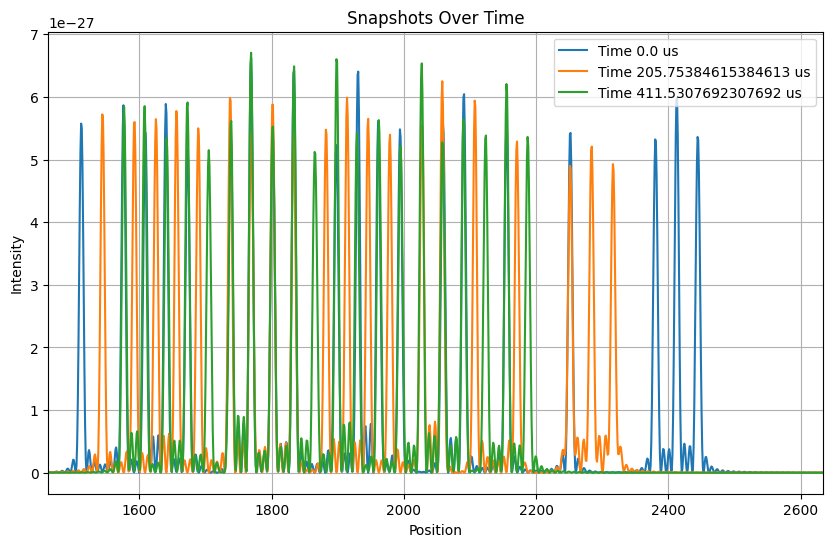

In [98]:
plot_snapshots(potentials, 3, globalvariables)

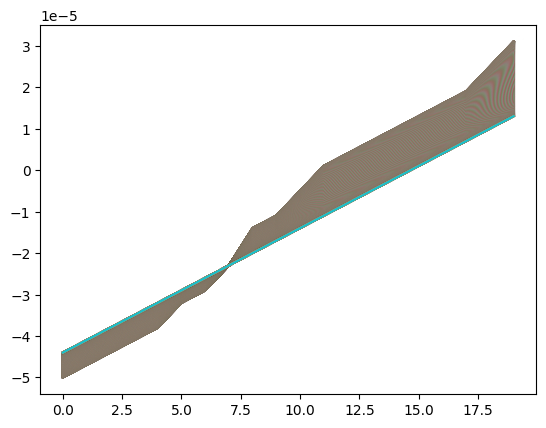

In [58]:
plt.plot(movements)

In [5]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)

expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
expanded_acceleration, expanded_time = expand_position_array(time, optimized_acceleration, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
init_forces = retrieveforces(AWGinitguessexponential, globalvariables, 10, True)
init_potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 10, True)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

Maximum error: 1.3259949582788977e-06


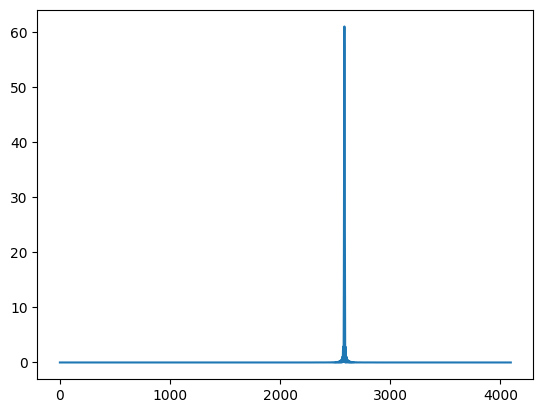

4.112822880227772
2583.8687489948843
10000
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4959
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4959
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.2685
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.1804
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.3898
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4322
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4724
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4953
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4961
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4961
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.3005
waveform made
forces made
xout re

c:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\TweezerOptimization\aodfunctions\general.py:1131: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(objective_survivalLegendre,tonumpy(initial_guess),method='Powell',options={'disp': True,'maxfev':100,'maxiter':1, 'xtol': 1e-2, 'ftol': 1e-2})


In [6]:
optimizedwaveform, optimizedLegendre, AWGwave_template = opt_atomsurvival_Legendre(fittedwaveform, fittedlegendre, 100e-6, globalvariables)
# optimizedwaveform, optimizedLegendre = opt_atomsurvival_PhaseOnly(AWGinitguess,500, 1e-6, globalvariables)
# optimizedwaveform, optimizedLegendre, AWGwave_template = opt_forces_Legendre(fittedwaveform, expanded_position, expanded_acceleration, fittedlegendre, globalvariables)


In [7]:
optimized_forces = retrieveforces(exponentialphaseresponse(optimizedwaveform), globalvariables, 10, True)
optimized_potentials = retrievepotentials(exponentialphaseresponse(optimizedwaveform), globalvariables, 10, True)

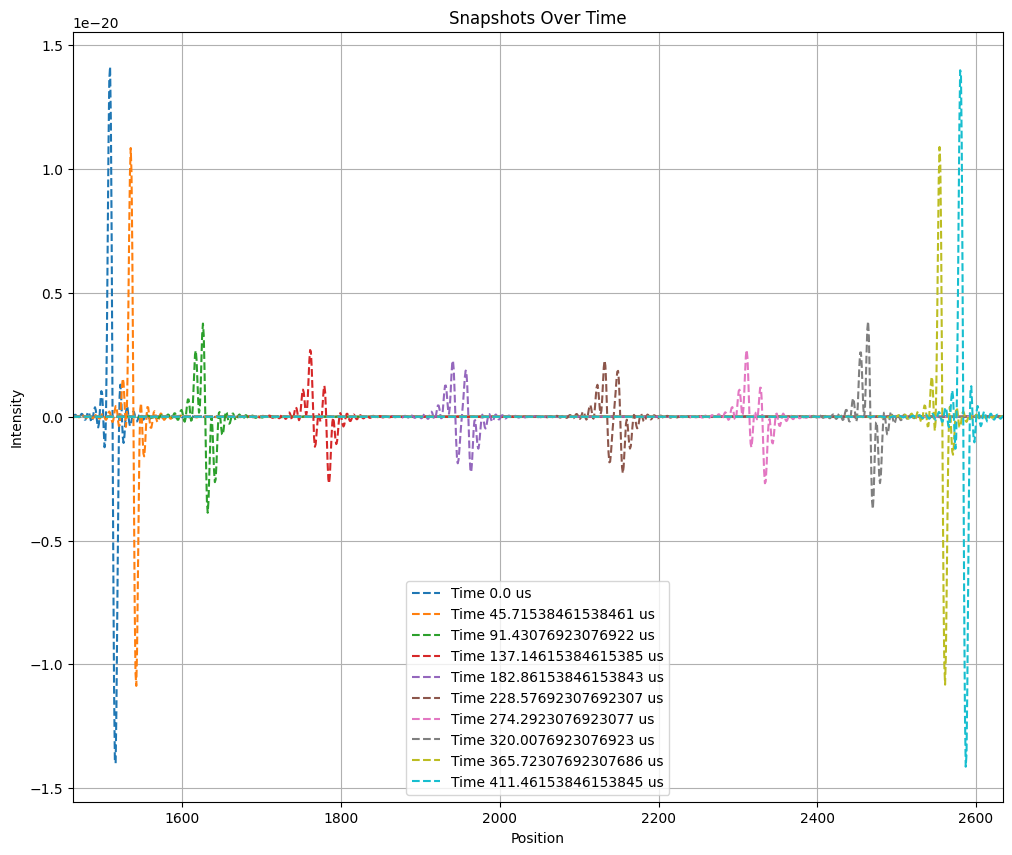

In [8]:


def plot_snapshots(frames, numsnapshots, globalvariables, figuresize = (10,6),filterOn=True):
    """
    Plot the frames of an input array at multiple points in time. Final graph has all the plots overlaid.
    
    Parameters:
    frames (cp.ndarray): Array of frames, each of which contains a 1D array representing a snapshot.
    numsnapshots (int): Number of snapshots to plot, evenly distributed throughout the frames array.
    globalvariables (dict): A dictionary of global variables.
    filterOn (bool, optional): Whether to apply an xlim filter to the snapshots. Default is True.
    """
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    # Convert cupy array to numpy array for compatibility with matplotlib
    frames = tonumpy(frames)
    
    # Calculate the indices for the snapshots to plot
    indices = np.linspace(0, len(frames) - 1, numsnapshots, dtype=int)
    
    plt.figure(figsize=figuresize)
    
    for idx in indices:
        snapshot = frames[idx]
        
        # Plot each snapshot
        plt.plot(snapshot, '--', label=f'Time {idx * timestep*10**6} us')
    
    if filterOn:
        # Apply xlim filter based on global variables
        xlim_min = positionstofourier(startlocation, 0, globalvariables)[0] - 50
        xlim_max = positionstofourier(endlocation, 0, globalvariables)[0] + 50
        plt.xlim(xlim_min, xlim_max)
    
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.title('Snapshots Over Time')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_snapshots(init_forces, 10, globalvariables, (12,10), filterOn=True)


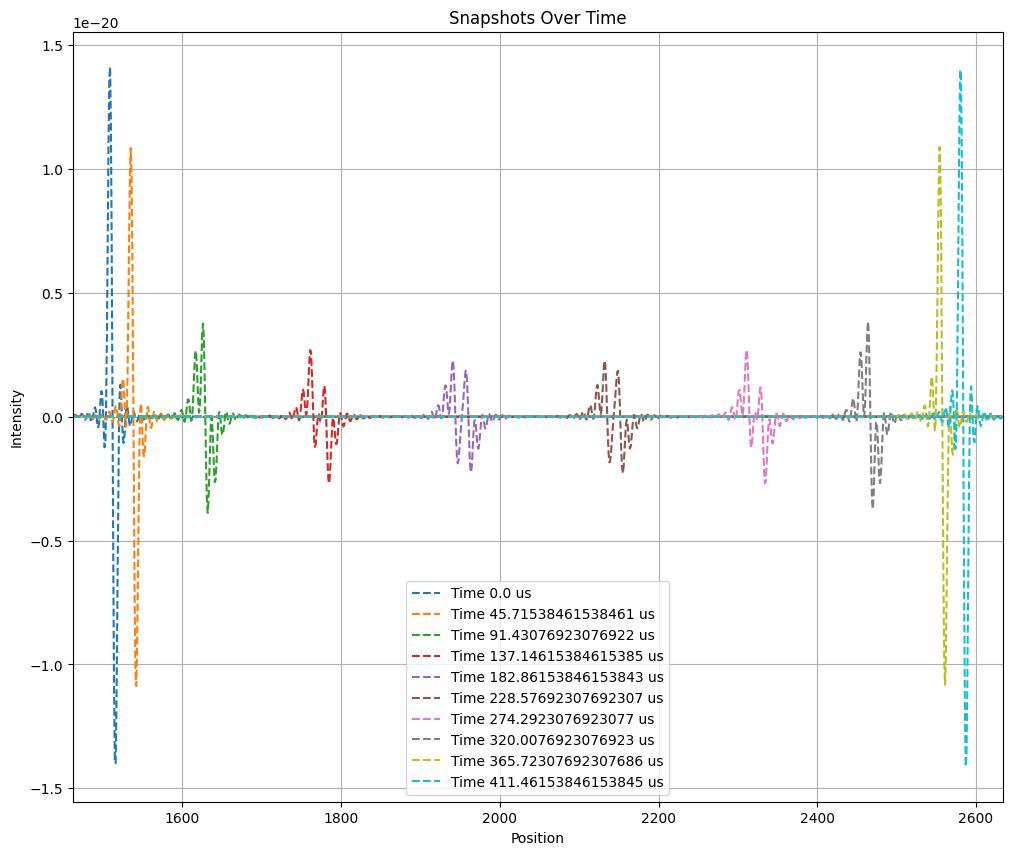

In [9]:
plot_snapshots(optimized_forces, 10, globalvariables, (12,10), filterOn=True)


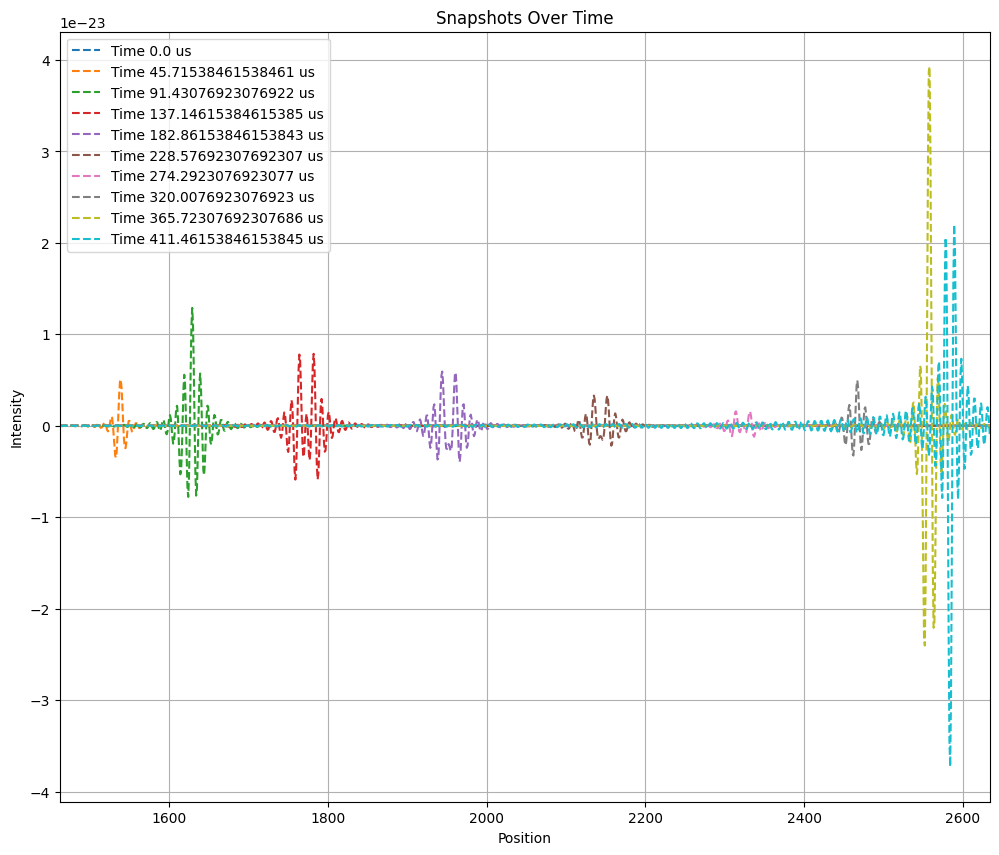

In [10]:
plot_snapshots(optimized_forces - init_forces, 10, globalvariables, (12,10), filterOn=True)


(1800.0, 2000.0)

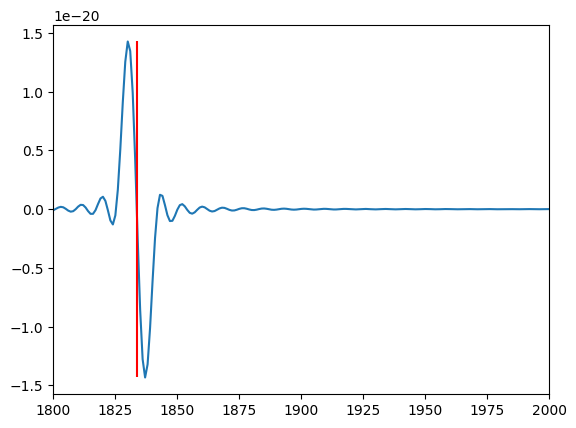

In [41]:
plt.plot(init_forces[0])
plt.vlines(x=positionstofourier(endlocation, time, globalvariables)[0], ymin = init_forces[0].min(), ymax = init_forces[0].max(), color = 'r')
plt.vlines(x=positionstofourier(startlocation, time, globalvariables)[0], ymin = init_forces[0].min(), ymax = init_forces[0].max(), color = 'r')
plt.xlim(1800,2000)

In [41]:
expanded_position

array([1833.66195709, 1833.66212   , 1833.66228292, ..., 2262.33771708,
       2262.33788   , 2262.33804291])

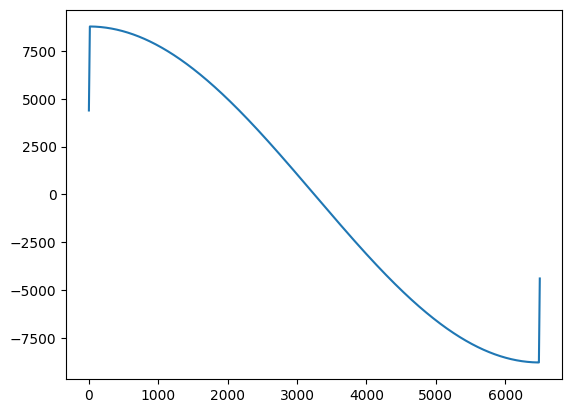

In [43]:
plt.plot(expanded_acceleration)

In [ ]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

In [17]:
movetimes = np.arange(70,150,10)*10**(-6)
movetemperatures = np.array([1])*10**(-6)

# movetimes = np.array([200])*10**(-6)
# movetemperatures = np.array([1])*10**(-6)


# ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "Linear", 1, globalvariables)
# notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "Linear", 1, globalvariables)
# idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "SinSq", 10, globalvariables)


1.922890580321072e-21
2155.203920338645
2.2493147708407158e-21
2155.2014233928767
2.652585743533475e-21
2155.1992828222524
2.812492856172391e-21
2155.1974316227966
2.8576372773459125e-21
2155.195858430982
2.9628432542848797e-21
2155.194502091825
3.987054106153568e-21
2155.193325699784
4.972552343690511e-21
2155.1922935089087


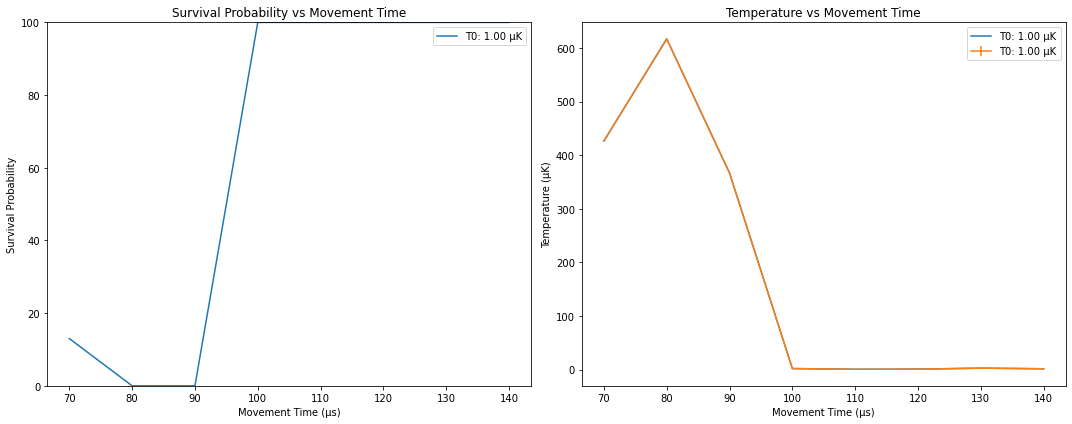

In [18]:
plots_fixeddistance(movetimes, movetemperatures, notidealsinsq)

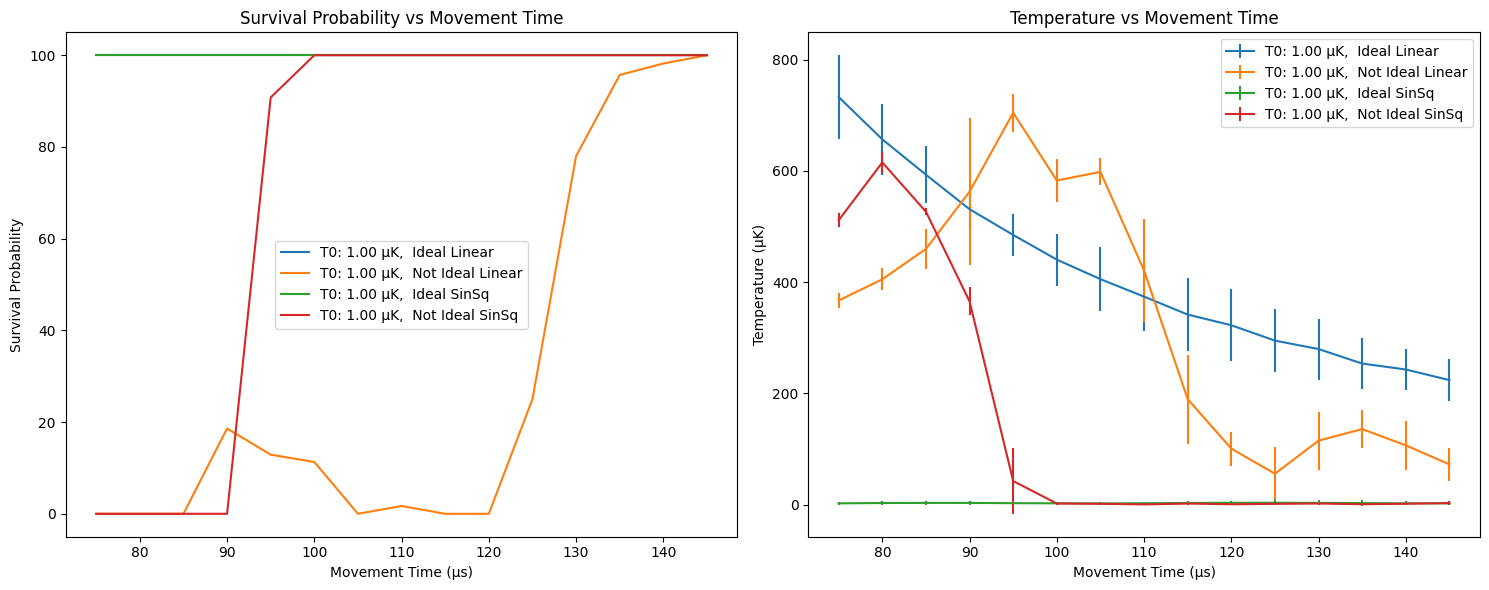

In [55]:
plots_fixeddistance_multipleanalysis(movetimes, movetemperatures, np.array([ideallinear, notideallinear, idealsinsq, notidealsinsq]), np.array(["Ideal Linear", "Not Ideal Linear", "Ideal SinSq", "Not Ideal SinSq"]))

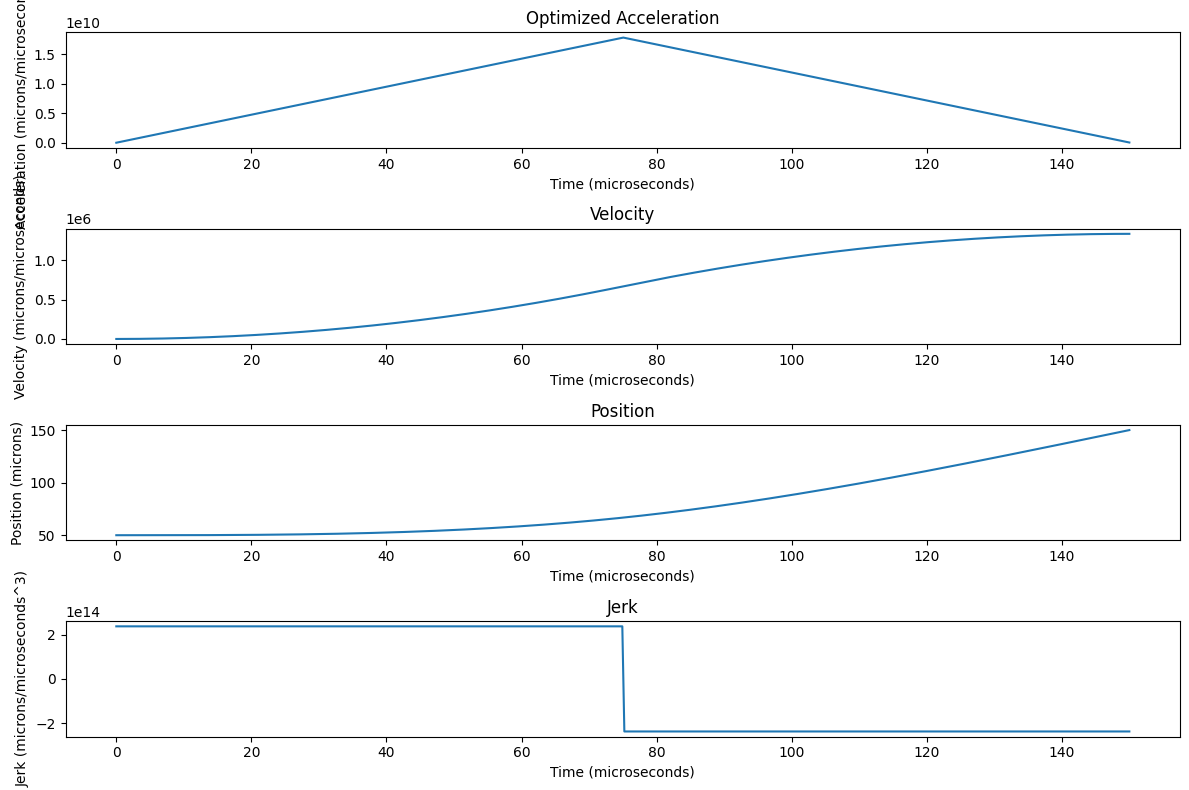

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()